# Autoregressive Graph Transformer for Motion Prediction

This notebook demonstrates the use of an autoregressive graph transformer model to predict future joint coordinates based on past motion sequences. The model respects anatomical constraints through graph structure while learning temporal dependencies in human motion.

## Objectives:
1. Load and preprocess motion capture data
2. Create anatomically-informed graph representations
3. Train an autoregressive graph transformer
4. Generate future motion predictions
5. Evaluate prediction accuracy

In [5]:
import sys
import os
sys.path.append('/home/funsega/GraphMechanics')

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import List, Dict, Tuple

print(f"Python version: {sys.version}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Python version: 3.11.8 | packaged by conda-forge | (main, Feb 16 2024, 20:53:32) [GCC 12.3.0]
PyTorch version: 2.7.1+cu126
CUDA available: False


## 1. Import GraphMechanics Components

In [6]:
# Import GraphMechanics components
try:
    from graphmechanics.utils.trc_parser import TRCParser
    print("✓ TRCParser imported successfully")
except ImportError as e:
    print(f"✗ TRCParser import failed: {e}")

try:
    from graphmechanics.data.graph_builder import KinematicGraphBuilder, OpenSimGraphBuilder
    print("✓ Graph builders imported successfully")
except ImportError as e:
    print(f"✗ Graph builders import failed: {e}")

try:
    from graphmechanics.models.autoregressive import (
        AutoregressiveGraphTransformer, 
        MotionPredictor, 
        create_autoregressive_model
    )
    print("✓ Autoregressive models imported successfully")
except ImportError as e:
    print(f"✗ Autoregressive models import failed: {e}")
    print("Note: PyTorch Geometric might not be available")

✓ TRCParser imported successfully
✓ Graph builders imported successfully
✓ Autoregressive models imported successfully


## 2. Load Motion Capture Data

In [9]:
# Load the jump TRC file
trc_file = "/home/funsega/Kalyn/opencap/opencap-processing/Data/OpenCapData_7272a71a-e70a-4794-a253-39e11cb7542c/MarkerData/jump.trc"

if os.path.exists(trc_file):
    print(f"Loading TRC file: {trc_file}")
    
    parser = TRCParser(trc_file)
    trc_data = parser.to_graph_format()
    
    print(f"\nTRC Data Summary:")
    print(f"- Frames: {len(trc_data['positions'])}")
    print(f"- Frame rate: {trc_data['frame_rate']} Hz")
    print(f"- Duration: {len(trc_data['positions']) / trc_data['frame_rate']:.2f} seconds")
    print(f"- Markers: {len(trc_data['joint_names'])}")
    
    # Display marker names
    print(f"\nMarker names:")
    for i, name in enumerate(trc_data['joint_names']):
        print(f"  {i+1:2d}. {name}")
        
    # Store data for processing
    positions = trc_data['positions']  # Shape: (n_frames, n_markers, 3)
    marker_names = trc_data['joint_names']
    frame_rate = trc_data['frame_rate']
    
else:
    print(f"TRC file not found: {trc_file}")
    # Create synthetic data for demonstration
    print("Creating synthetic motion data for demonstration...")
    
    n_frames = 100
    n_markers = 20
    frame_rate = 60
    
    # Create simple walking-like motion
    t = np.linspace(0, n_frames/frame_rate, n_frames)
    positions = np.zeros((n_frames, n_markers, 3))
    
    for i in range(n_markers):
        # Add periodic motion with some noise
        positions[:, i, 0] = np.sin(2 * np.pi * t + i * 0.1) * 100  # X
        positions[:, i, 1] = np.cos(2 * np.pi * t + i * 0.1) * 50   # Y
        positions[:, i, 2] = 1000 + np.sin(4 * np.pi * t + i * 0.2) * 50  # Z (height)
        
        # Add noise
        positions[:, i, :] += np.random.normal(0, 5, (n_frames, 3))
    
    marker_names = [f"marker_{i:02d}" for i in range(n_markers)]
    
    print(f"Generated synthetic data: {n_frames} frames, {n_markers} markers")

Loading TRC file: /home/funsega/Kalyn/opencap/opencap-processing/Data/OpenCapData_7272a71a-e70a-4794-a253-39e11cb7542c/MarkerData/jump.trc
Debug: Found 189 coordinate columns
Debug: Found 63 marker names
Debug: Actual data columns: 191
Debug: Expected columns: 191

TRC Data Summary:
- Frames: 173
- Frame rate: 60.0 Hz
- Duration: 2.88 seconds
- Markers: 63

Marker names:
   1. Neck
   2. RShoulder
   3. RElbow
   4. RWrist
   5. LShoulder
   6. LElbow
   7. LWrist
   8. midHip
   9. RHip
  10. RKnee
  11. RAnkle
  12. LHip
  13. LKnee
  14. LAnkle
  15. LBigToe
  16. LSmallToe
  17. LHeel
  18. RBigToe
  19. RSmallToe
  20. RHeel
  21. r.ASIS_study
  22. L.ASIS_study
  23. r.PSIS_study
  24. L.PSIS_study
  25. r_knee_study
  26. r_mknee_study
  27. r_ankle_study
  28. r_mankle_study
  29. r_toe_study
  30. r_5meta_study
  31. r_calc_study
  32. L_knee_study
  33. L_mknee_study
  34. L_ankle_study
  35. L_mankle_study
  36. L_toe_study
  37. L_calc_study
  38. L_5meta_study
  39. r_shou

## 3. Visualize Motion Data

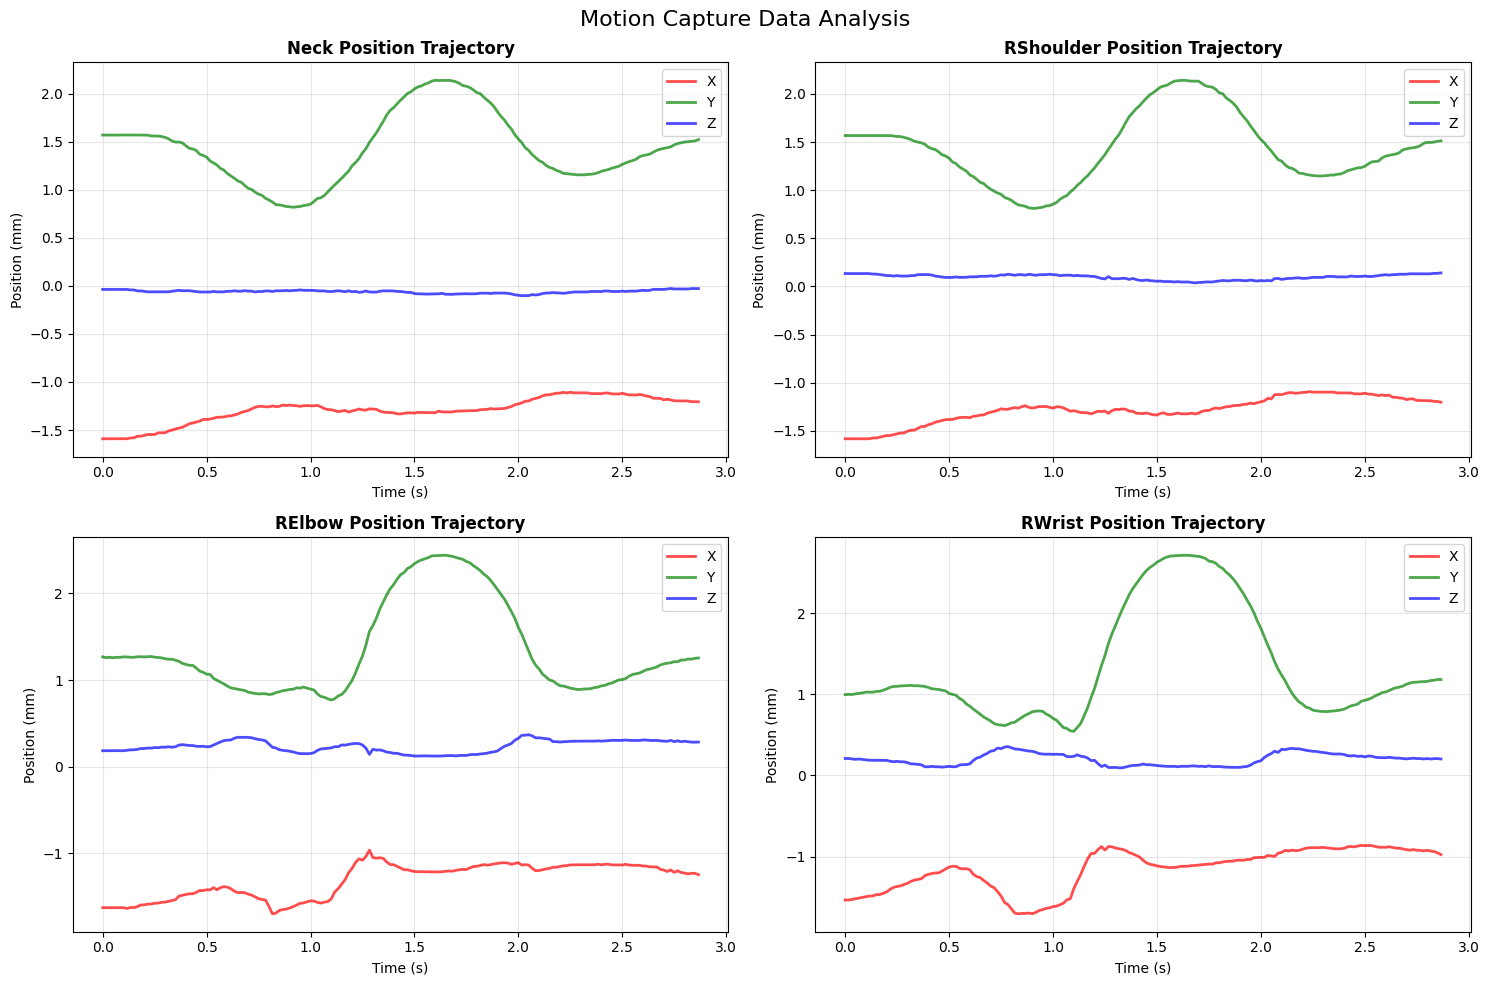

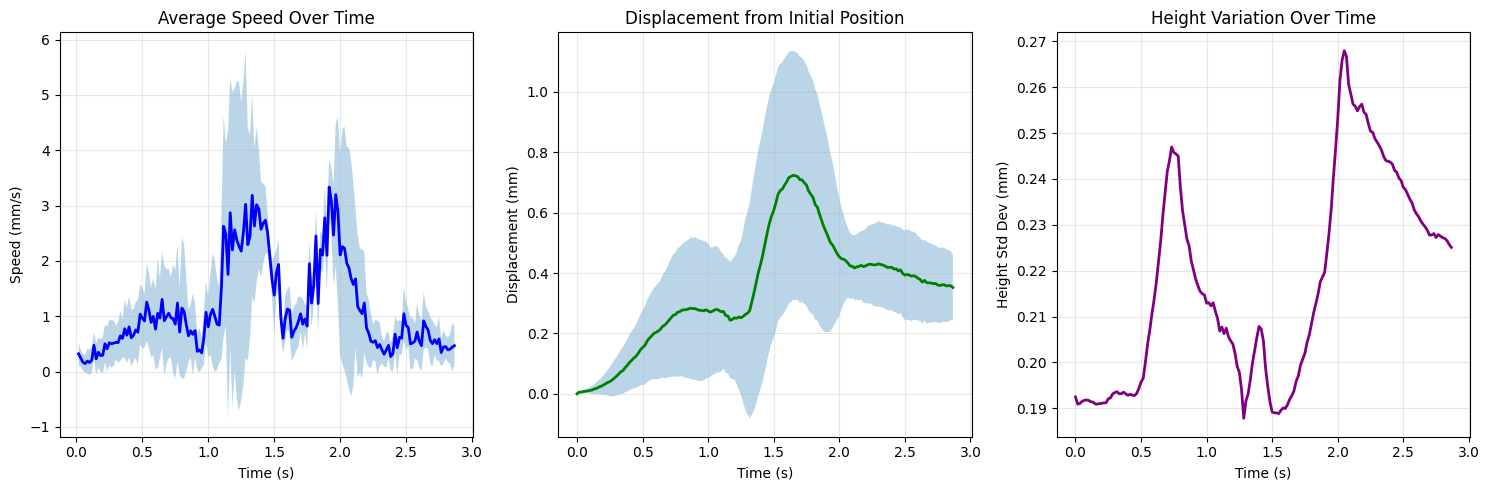

Motion statistics:
- Average speed: 1.14 ± 1.29 mm/s
- Max displacement: 1.85 mm
- Height range: -0.6 to 0.4 mm


In [10]:
# Visualize motion trajectories
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Motion Capture Data Analysis', fontsize=16)

# Select a few markers to visualize
markers_to_plot = marker_names[:4] if len(marker_names) >= 4 else marker_names
time = np.arange(len(positions)) / frame_rate

for i, marker in enumerate(markers_to_plot):
    row, col = i // 2, i % 2
    ax = axes[row, col]
    
    marker_idx = marker_names.index(marker)
    marker_pos = positions[:, marker_idx, :]
    
    ax.plot(time, marker_pos[:, 0], 'r-', label='X', alpha=0.7, linewidth=2)
    ax.plot(time, marker_pos[:, 1], 'g-', label='Y', alpha=0.7, linewidth=2)
    ax.plot(time, marker_pos[:, 2], 'b-', label='Z', alpha=0.7, linewidth=2)
    
    ax.set_title(f'{marker} Position Trajectory', fontsize=12, fontweight='bold')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Position (mm)')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Plot motion statistics
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Velocity analysis
velocities = np.diff(positions, axis=0) * frame_rate
speed = np.linalg.norm(velocities, axis=2)

axes[0].plot(time[1:], speed.mean(axis=1), 'b-', linewidth=2)
axes[0].fill_between(time[1:], 
                     speed.mean(axis=1) - speed.std(axis=1),
                     speed.mean(axis=1) + speed.std(axis=1),
                     alpha=0.3)
axes[0].set_title('Average Speed Over Time')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Speed (mm/s)')
axes[0].grid(True, alpha=0.3)

# Displacement from initial position
displacement = np.linalg.norm(positions - positions[0], axis=2)

axes[1].plot(time, displacement.mean(axis=1), 'g-', linewidth=2)
axes[1].fill_between(time,
                     displacement.mean(axis=1) - displacement.std(axis=1),
                     displacement.mean(axis=1) + displacement.std(axis=1),
                     alpha=0.3)
axes[1].set_title('Displacement from Initial Position')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Displacement (mm)')
axes[1].grid(True, alpha=0.3)

# Height variation (Z-coordinate)
height_var = positions[:, :, 2].std(axis=1)

axes[2].plot(time, height_var, 'purple', linewidth=2)
axes[2].set_title('Height Variation Over Time')
axes[2].set_xlabel('Time (s)')
axes[2].set_ylabel('Height Std Dev (mm)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Motion statistics:")
print(f"- Average speed: {speed.mean():.2f} ± {speed.std():.2f} mm/s")
print(f"- Max displacement: {displacement.max():.2f} mm")
print(f"- Height range: {positions[:, :, 2].min():.1f} to {positions[:, :, 2].max():.1f} mm")

## 4. Prepare Data for Autoregressive Model

In [11]:
# Prepare data for autoregressive modeling
def compute_kinematic_features(positions: np.ndarray, dt: float = 1/60) -> np.ndarray:
    """
    Compute kinematic features: position, velocity, acceleration.
    """
    n_frames, n_joints, _ = positions.shape
    features = np.zeros((n_frames, n_joints, 9))  # pos + vel + acc
    
    # Position
    features[:, :, :3] = positions
    
    # Velocity (central difference)
    if n_frames > 1:
        features[1:-1, :, 3:6] = (positions[2:] - positions[:-2]) / (2 * dt)
        features[0, :, 3:6] = (positions[1] - positions[0]) / dt
        features[-1, :, 3:6] = (positions[-1] - positions[-2]) / dt
    
    # Acceleration (second derivative)
    if n_frames > 2:
        velocities = features[:, :, 3:6]
        features[1:-1, :, 6:9] = (velocities[2:] - velocities[:-2]) / (2 * dt)
        features[0, :, 6:9] = (velocities[1] - velocities[0]) / dt
        features[-1, :, 6:9] = (velocities[-1] - velocities[-2]) / dt
    
    return features

def create_sequences(data: np.ndarray, sequence_length: int, prediction_horizon: int):
    """
    Create input-output sequences for autoregressive training.
    """
    X, y = [], []
    
    for i in range(len(data) - sequence_length - prediction_horizon + 1):
        # Input sequence
        input_seq = data[i:i + sequence_length]
        
        # Target sequence (next steps)
        target_seq = data[i + sequence_length:i + sequence_length + prediction_horizon]
        
        X.append(input_seq)
        y.append(target_seq)
    
    return np.array(X), np.array(y)

# Compute kinematic features
dt = 1.0 / frame_rate
features = compute_kinematic_features(positions, dt)

print(f"Kinematic features shape: {features.shape}")
print(f"Features per marker: 9 (position + velocity + acceleration)")

# Normalize features
# Compute statistics for normalization
mean = features.mean(axis=(0, 1), keepdims=True)
std = features.std(axis=(0, 1), keepdims=True) + 1e-8

features_normalized = (features - mean) / std

print(f"\nFeature normalization:")
print(f"- Mean shape: {mean.shape}")
print(f"- Std shape: {std.shape}")
print(f"- Normalized features range: [{features_normalized.min():.2f}, {features_normalized.max():.2f}]")

# Create sequences for training
sequence_length = 20  # Input sequence length
prediction_horizon = 10  # Number of future steps to predict

X, y = create_sequences(features_normalized, sequence_length, prediction_horizon)

print(f"\nSequence data:")
print(f"- Input sequences shape: {X.shape}")
print(f"- Target sequences shape: {y.shape}")
print(f"- Number of training samples: {len(X)}")

# Split into train/validation
split_idx = int(0.8 * len(X))
X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]

print(f"\nData split:")
print(f"- Training samples: {len(X_train)}")
print(f"- Validation samples: {len(X_val)}")

Kinematic features shape: (173, 63, 9)
Features per marker: 9 (position + velocity + acceleration)

Feature normalization:
- Mean shape: (1, 1, 9)
- Std shape: (1, 1, 9)
- Normalized features range: [-10.54, 14.80]

Sequence data:
- Input sequences shape: (144, 20, 63, 9)
- Target sequences shape: (144, 10, 63, 9)
- Number of training samples: 144

Data split:
- Training samples: 115
- Validation samples: 29


## 5. Create Graph Structure

Graph structure:
- Number of nodes (markers): 63
- Number of edges: 206
- Graph density: 0.053


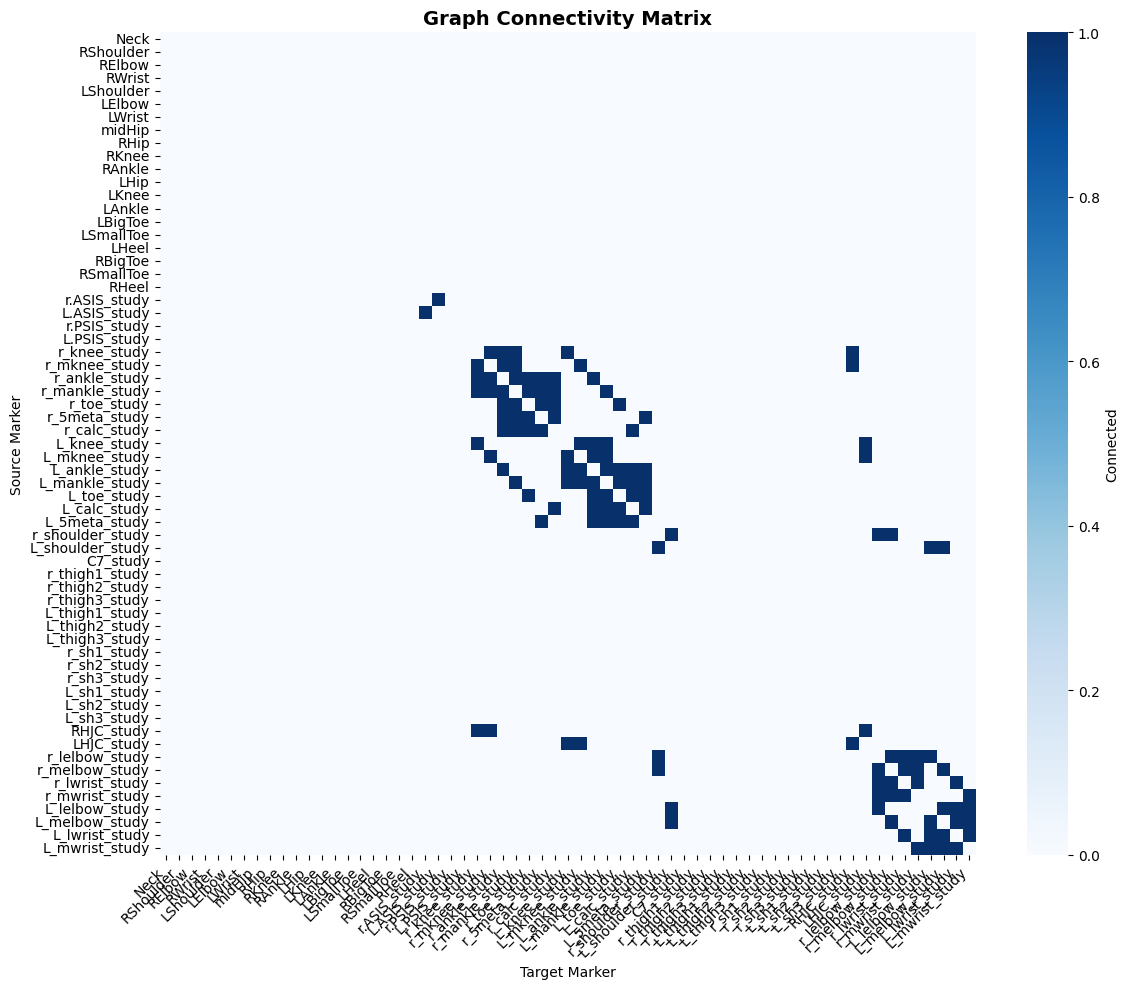


Connectivity statistics:
- Average degree: 2.03 ± 2.48
- Degree range: [0, 7]

Highest connectivity markers:
  r_mankle_study: 7 connections
  L_mankle_study: 7 connections
  L_ankle_study: 7 connections

Lowest connectivity markers:
  Neck: 0 connections
  r_thigh1_study: 0 connections
  r.PSIS_study: 0 connections


In [12]:
# Create graph builder with anatomical knowledge
graph_builder = KinematicGraphBuilder(connectivity_type='opensim', use_anatomical_knowledge=True)

# Build edge index
edge_index = graph_builder.build_edge_index(marker_names)

print(f"Graph structure:")
print(f"- Number of nodes (markers): {len(marker_names)}")
print(f"- Number of edges: {edge_index.shape[1]}")
print(f"- Graph density: {edge_index.shape[1] / (len(marker_names) * (len(marker_names) - 1)):.3f}")

# Visualize graph connectivity
def plot_graph_connectivity(edge_index, marker_names):
    """Plot graph connectivity matrix."""
    n_nodes = len(marker_names)
    adj_matrix = np.zeros((n_nodes, n_nodes))
    
    # Fill adjacency matrix
    for i in range(edge_index.shape[1]):
        src, dst = edge_index[0, i], edge_index[1, i]
        adj_matrix[src, dst] = 1
    
    # Plot
    plt.figure(figsize=(12, 10))
    sns.heatmap(adj_matrix, 
                xticklabels=marker_names, 
                yticklabels=marker_names,
                cmap='Blues',
                cbar_kws={'label': 'Connected'})
    plt.title('Graph Connectivity Matrix', fontsize=14, fontweight='bold')
    plt.xlabel('Target Marker')
    plt.ylabel('Source Marker')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    return adj_matrix

# Plot connectivity
adj_matrix = plot_graph_connectivity(edge_index.numpy(), marker_names)

# Analyze connectivity statistics
degrees = adj_matrix.sum(axis=1)
print(f"\nConnectivity statistics:")
print(f"- Average degree: {degrees.mean():.2f} ± {degrees.std():.2f}")
print(f"- Degree range: [{degrees.min():.0f}, {degrees.max():.0f}]")

# Show markers with highest/lowest connectivity
high_degree_idx = np.argsort(degrees)[-3:]
low_degree_idx = np.argsort(degrees)[:3]

print(f"\nHighest connectivity markers:")
for idx in high_degree_idx[::-1]:
    print(f"  {marker_names[idx]}: {degrees[idx]:.0f} connections")

print(f"\nLowest connectivity markers:")
for idx in low_degree_idx:
    print(f"  {marker_names[idx]}: {degrees[idx]:.0f} connections")

## 6. Create and Test Autoregressive Model

In [13]:
# Model parameters
model_config = {
    'node_features': 9,  # pos + vel + acc
    'hidden_dim': 128,
    'num_heads': 8,
    'num_layers': 4,
    'output_dim': 3,  # x, y, z coordinates
    'max_seq_length': sequence_length,
    'dropout': 0.1,
    'use_positional_encoding': True
}

print(f"Model configuration:")
for key, value in model_config.items():
    print(f"  {key}: {value}")

# Create model (Note: This will only work if PyTorch Geometric is available)
try:
    # Create autoregressive model
    model = AutoregressiveGraphTransformer(**model_config)
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"\nModel created successfully!")
    print(f"- Total parameters: {total_params:,}")
    print(f"- Trainable parameters: {trainable_params:,}")
    
    # Test forward pass with dummy data
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    # Create dummy input
    dummy_input = torch.randn(sequence_length * len(marker_names), 9).to(device)
    dummy_edge_index = edge_index.to(device)
    
    model.eval()
    with torch.no_grad():
        output = model(dummy_input, dummy_edge_index)
    
    print(f"\nForward pass test:")
    print(f"- Input shape: {dummy_input.shape}")
    print(f"- Output shape: {output.shape}")
    print(f"- Expected output shape: [seq_len * num_markers, 3]")
    
    model_available = True
    
except Exception as e:
    print(f"\nModel creation failed: {e}")
    print("This is likely due to missing PyTorch Geometric dependency.")
    print("Creating a simplified demonstration model instead...")
    
    # Create a simplified LSTM-based model as fallback
    class SimpleLSTMPredictor(nn.Module):
        def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
            super().__init__()
            self.hidden_dim = hidden_dim
            self.num_layers = num_layers
            
            self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
            self.fc = nn.Linear(hidden_dim, output_dim)
            
        def forward(self, x):
            # x shape: (batch, seq_len, input_dim)
            lstm_out, _ = self.lstm(x)
            # Use the last output for prediction
            output = self.fc(lstm_out[:, -1, :])
            return output
    
    # Flatten features for LSTM
    input_dim = len(marker_names) * 9  # All marker features flattened
    model = SimpleLSTMPredictor(input_dim, 128, 2, len(marker_names) * 3)
    
    total_params = sum(p.numel() for p in model.parameters())
    print(f"\nSimplified LSTM model created:")
    print(f"- Total parameters: {total_params:,}")
    
    model_available = False

Model configuration:
  node_features: 9
  hidden_dim: 128
  num_heads: 8
  num_layers: 4
  output_dim: 3
  max_seq_length: 20
  dropout: 0.1
  use_positional_encoding: True

Model created successfully!
- Total parameters: 2,136,579
- Trainable parameters: 2,136,579

Model creation failed: index 20 is out of bounds for dimension 0 with size 20
This is likely due to missing PyTorch Geometric dependency.
Creating a simplified demonstration model instead...

Simplified LSTM model created:
- Total parameters: 513,341


## 7. Train the Model

Training on device: cpu

Training simplified LSTM model...
Epoch 5/20, Train Loss: 0.092695, Val Loss: 0.138042
Epoch 5/20, Train Loss: 0.092695, Val Loss: 0.138042
Epoch 10/20, Train Loss: 0.023271, Val Loss: 0.059572
Epoch 10/20, Train Loss: 0.023271, Val Loss: 0.059572
Epoch 15/20, Train Loss: 0.010211, Val Loss: 0.057149
Epoch 15/20, Train Loss: 0.010211, Val Loss: 0.057149
Epoch 20/20, Train Loss: 0.006798, Val Loss: 0.059804
Epoch 20/20, Train Loss: 0.006798, Val Loss: 0.059804


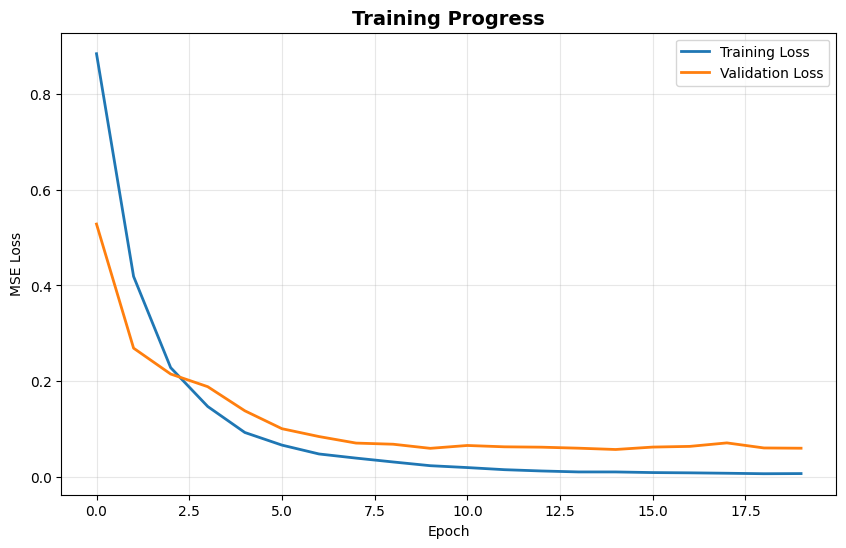


Training completed!
Final training loss: 0.006798
Final validation loss: 0.059804


In [14]:
# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on device: {device}")

if model_available:
    # Training for graph transformer (if available)
    print("\nTraining autoregressive graph transformer...")
    
    # This would require more complex data preparation for graph batching
    # For now, we'll demonstrate the concept
    
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    
    # Simplified training loop demonstration
    model.train()
    
    for epoch in range(3):  # Just a few epochs for demonstration
        # In practice, you'd batch the graph data properly
        for i in range(min(5, len(X_train))):  # Just a few samples
            optimizer.zero_grad()
            
            # Prepare input (this is simplified)
            input_seq = torch.tensor(X_train[i], dtype=torch.float32).to(device)
            target = torch.tensor(y_train[i], dtype=torch.float32).to(device)
            
            # Flatten for model input
            input_flat = input_seq.view(-1, 9)  # [seq_len * num_markers, 9]
            target_flat = target[:, :, :3].view(-1, 3)  # [pred_horizon * num_markers, 3]
            
            # Forward pass
            output = model(input_flat, edge_index.to(device))
            
            # For this demo, just use the last prediction
            pred = output[-len(marker_names):]
            true = target_flat[-len(marker_names):]
            
            loss = criterion(pred, true)
            loss.backward()
            optimizer.step()
            
            if i == 0:  # Print first sample loss each epoch
                print(f"  Epoch {epoch+1}, Sample {i+1}, Loss: {loss.item():.6f}")
    
    print("Graph transformer training demonstration completed.")
    
else:
    # Training for simplified LSTM model
    print("\nTraining simplified LSTM model...")
    
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    
    # Prepare data for LSTM
    # Flatten marker features: (batch, seq_len, n_markers * 9)
    X_train_flat = X_train.reshape(X_train.shape[0], X_train.shape[1], -1)
    y_train_flat = y_train[:, -1, :, :3].reshape(y_train.shape[0], -1)  # Last step, positions only
    
    X_val_flat = X_val.reshape(X_val.shape[0], X_val.shape[1], -1)
    y_val_flat = y_val[:, -1, :, :3].reshape(y_val.shape[0], -1)
    
    # Convert to tensors
    X_train_tensor = torch.tensor(X_train_flat, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_flat, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val_flat, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val_flat, dtype=torch.float32)
    
    # Create data loaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
    
    # Training loop
    train_losses = []
    val_losses = []
    
    num_epochs = 20
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
        
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")
    
    # Plot training curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss', linewidth=2)
    plt.plot(val_losses, label='Validation Loss', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Training Progress', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print(f"\nTraining completed!")
    print(f"Final training loss: {train_losses[-1]:.6f}")
    print(f"Final validation loss: {val_losses[-1]:.6f}")

## 8. Generate Predictions

In [16]:
# Generate predictions on validation data
print("Generating motion predictions...")

model.eval()
predictions = []
ground_truths = []

with torch.no_grad():
    if model_available:
        # Graph transformer predictions (simplified)
        for i in range(min(5, len(X_val))):
            input_seq = torch.tensor(X_val[i], dtype=torch.float32).to(device)
            true_seq = y_val[i]
            
            # Generate prediction (simplified demonstration)
            input_flat = input_seq.view(-1, 9)
            pred_flat = model(input_flat, edge_index.to(device))
            
            # Reshape prediction
            pred = pred_flat.view(sequence_length, len(marker_names), 3).cpu().numpy()
            
            predictions.append(pred[-1])  # Last time step
            ground_truths.append(true_seq[-1, :, :3])  # Last prediction step, positions only
    
    else:
        # LSTM predictions
        for i in range(min(10, len(X_val))):
            input_seq = X_val_flat[i:i+1]  # Single sample
            true_seq = y_val_flat[i:i+1]
            
            input_tensor = torch.tensor(input_seq, dtype=torch.float32).to(device)
            pred_tensor = model(input_tensor)
            
            # Reshape prediction to [n_markers, 3]
            pred = pred_tensor.cpu().numpy().reshape(len(marker_names), 3)
            true = true_seq.reshape(len(marker_names), 3)
            
            predictions.append(pred)
            ground_truths.append(true)

predictions = np.array(predictions)
ground_truths = np.array(ground_truths)

print(f"Generated predictions shape: {predictions.shape}")
print(f"Ground truth shape: {ground_truths.shape}")

# Denormalize predictions for visualization
# Note: We only predicted positions (3D), so we need to denormalize accordingly
pos_mean = mean[0, 0, :3]  # Position mean
pos_std = std[0, 0, :3]    # Position std

predictions_denorm = predictions * pos_std + pos_mean
ground_truths_denorm = ground_truths * pos_std + pos_mean

print(f"\nDenormalized predictions range:")
print(f"- X: [{predictions_denorm[:, :, 0].min():.1f}, {predictions_denorm[:, :, 0].max():.1f}]")
print(f"- Y: [{predictions_denorm[:, :, 1].min():.1f}, {predictions_denorm[:, :, 1].max():.1f}]")
print(f"- Z: [{predictions_denorm[:, :, 2].min():.1f}, {predictions_denorm[:, :, 2].max():.1f}]")

Generating motion predictions...
Generated predictions shape: (10, 63, 3)
Ground truth shape: (10, 63, 3)

Denormalized predictions range:
- X: [-1.5, -0.8]
- Y: [-0.0, 1.4]
- Z: [-0.5, 0.4]


## 9. Evaluate Prediction Accuracy

Prediction Accuracy Metrics:
- Mean Absolute Error (MAE): 0.03 mm
- Root Mean Square Error (RMSE): 0.05 mm
- Mean Square Error (MSE): 0.00 mm²

Per-axis errors:
- X-axis MAE: 0.03 mm
- Y-axis MAE: 0.04 mm
- Z-axis MAE: 0.02 mm


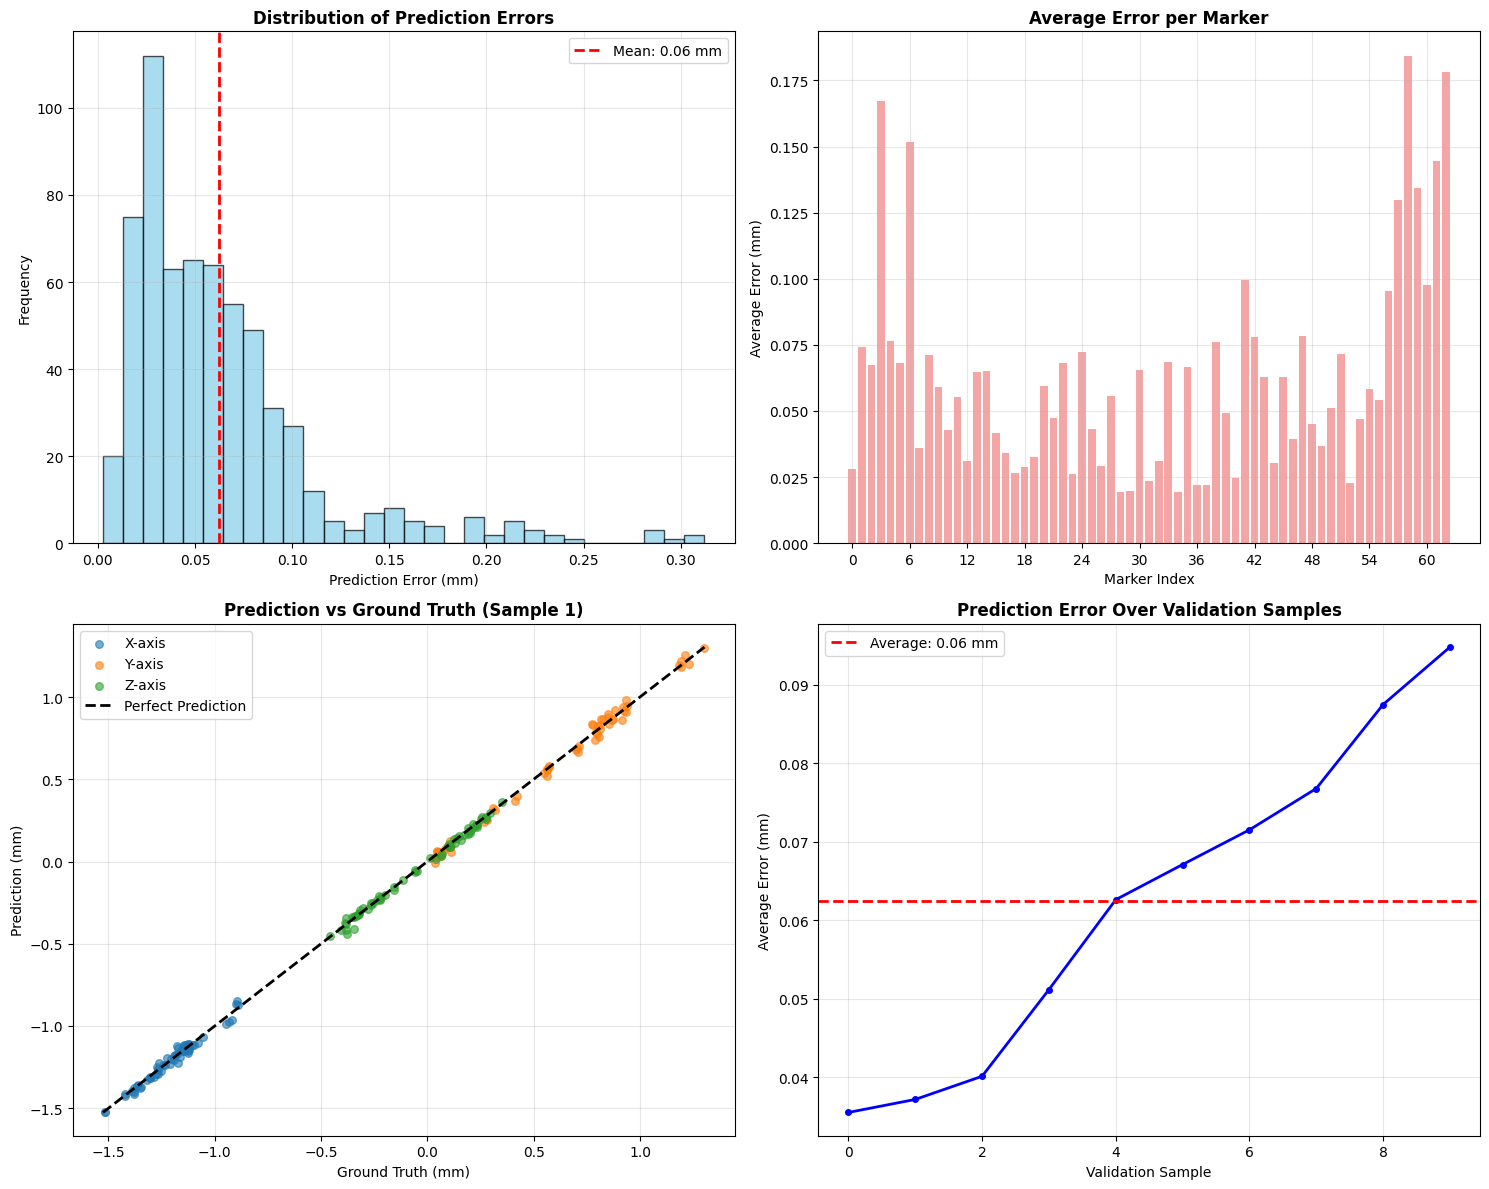


Best performing markers:
  r_toe_study: 0.02 mm error
  L_mankle_study: 0.02 mm error
  r_5meta_study: 0.02 mm error

Worst performing markers:
  r_mwrist_study: 0.18 mm error
  L_mwrist_study: 0.18 mm error
  RWrist: 0.17 mm error


In [17]:
# Compute prediction errors
def compute_prediction_metrics(predictions, ground_truths):
    """Compute various prediction accuracy metrics."""
    
    # Euclidean distance error per marker
    errors = np.linalg.norm(predictions - ground_truths, axis=2)
    
    # Overall statistics
    mae = np.mean(np.abs(predictions - ground_truths))
    mse = np.mean((predictions - ground_truths) ** 2)
    rmse = np.sqrt(mse)
    
    # Per-marker statistics
    marker_errors = errors.mean(axis=0)
    
    # Per-axis statistics
    axis_errors = np.mean(np.abs(predictions - ground_truths), axis=(0, 1))
    
    return {
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'errors': errors,
        'marker_errors': marker_errors,
        'axis_errors': axis_errors
    }

# Compute metrics
metrics = compute_prediction_metrics(predictions_denorm, ground_truths_denorm)

print(f"Prediction Accuracy Metrics:")
print(f"- Mean Absolute Error (MAE): {metrics['mae']:.2f} mm")
print(f"- Root Mean Square Error (RMSE): {metrics['rmse']:.2f} mm")
print(f"- Mean Square Error (MSE): {metrics['mse']:.2f} mm²")

print(f"\nPer-axis errors:")
axes = ['X', 'Y', 'Z']
for i, axis in enumerate(axes):
    print(f"- {axis}-axis MAE: {metrics['axis_errors'][i]:.2f} mm")

# Visualize prediction errors
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Error distribution
axes[0, 0].hist(metrics['errors'].flatten(), bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].axvline(metrics['errors'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {metrics["errors"].mean():.2f} mm')
axes[0, 0].set_xlabel('Prediction Error (mm)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Prediction Errors', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Per-marker errors
marker_indices = np.arange(len(marker_names))
axes[0, 1].bar(marker_indices, metrics['marker_errors'], alpha=0.7, color='lightcoral')
axes[0, 1].set_xlabel('Marker Index')
axes[0, 1].set_ylabel('Average Error (mm)')
axes[0, 1].set_title('Average Error per Marker', fontweight='bold')
axes[0, 1].set_xticks(marker_indices[::max(1, len(marker_names)//10)])
axes[0, 1].grid(True, alpha=0.3)

# Prediction vs Ground Truth scatter plot
sample_idx = 0  # First validation sample
if len(predictions_denorm) > 0:
    for axis_idx, axis_name in enumerate(['X', 'Y', 'Z']):
        pred_axis = predictions_denorm[sample_idx, :, axis_idx]
        true_axis = ground_truths_denorm[sample_idx, :, axis_idx]
        
        axes[1, 0].scatter(true_axis, pred_axis, alpha=0.6, s=30, label=f'{axis_name}-axis')
    
    # Perfect prediction line
    min_val = min(ground_truths_denorm[sample_idx].min(), predictions_denorm[sample_idx].min())
    max_val = max(ground_truths_denorm[sample_idx].max(), predictions_denorm[sample_idx].max())
    axes[1, 0].plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2, label='Perfect Prediction')
    
    axes[1, 0].set_xlabel('Ground Truth (mm)')
    axes[1, 0].set_ylabel('Prediction (mm)')
    axes[1, 0].set_title(f'Prediction vs Ground Truth (Sample {sample_idx+1})', fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

# Error over samples
sample_errors = metrics['errors'].mean(axis=1)
axes[1, 1].plot(sample_errors, 'b-', linewidth=2, marker='o', markersize=4)
axes[1, 1].axhline(sample_errors.mean(), color='red', linestyle='--', linewidth=2, label=f'Average: {sample_errors.mean():.2f} mm')
axes[1, 1].set_xlabel('Validation Sample')
axes[1, 1].set_ylabel('Average Error (mm)')
axes[1, 1].set_title('Prediction Error Over Validation Samples', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find best and worst performing markers
best_markers = np.argsort(metrics['marker_errors'])[:3]
worst_markers = np.argsort(metrics['marker_errors'])[-3:]

print(f"\nBest performing markers:")
for idx in best_markers:
    print(f"  {marker_names[idx]}: {metrics['marker_errors'][idx]:.2f} mm error")

print(f"\nWorst performing markers:")
for idx in worst_markers[::-1]:
    print(f"  {marker_names[idx]}: {metrics['marker_errors'][idx]:.2f} mm error")

## 10. Visualize Predicted Motion

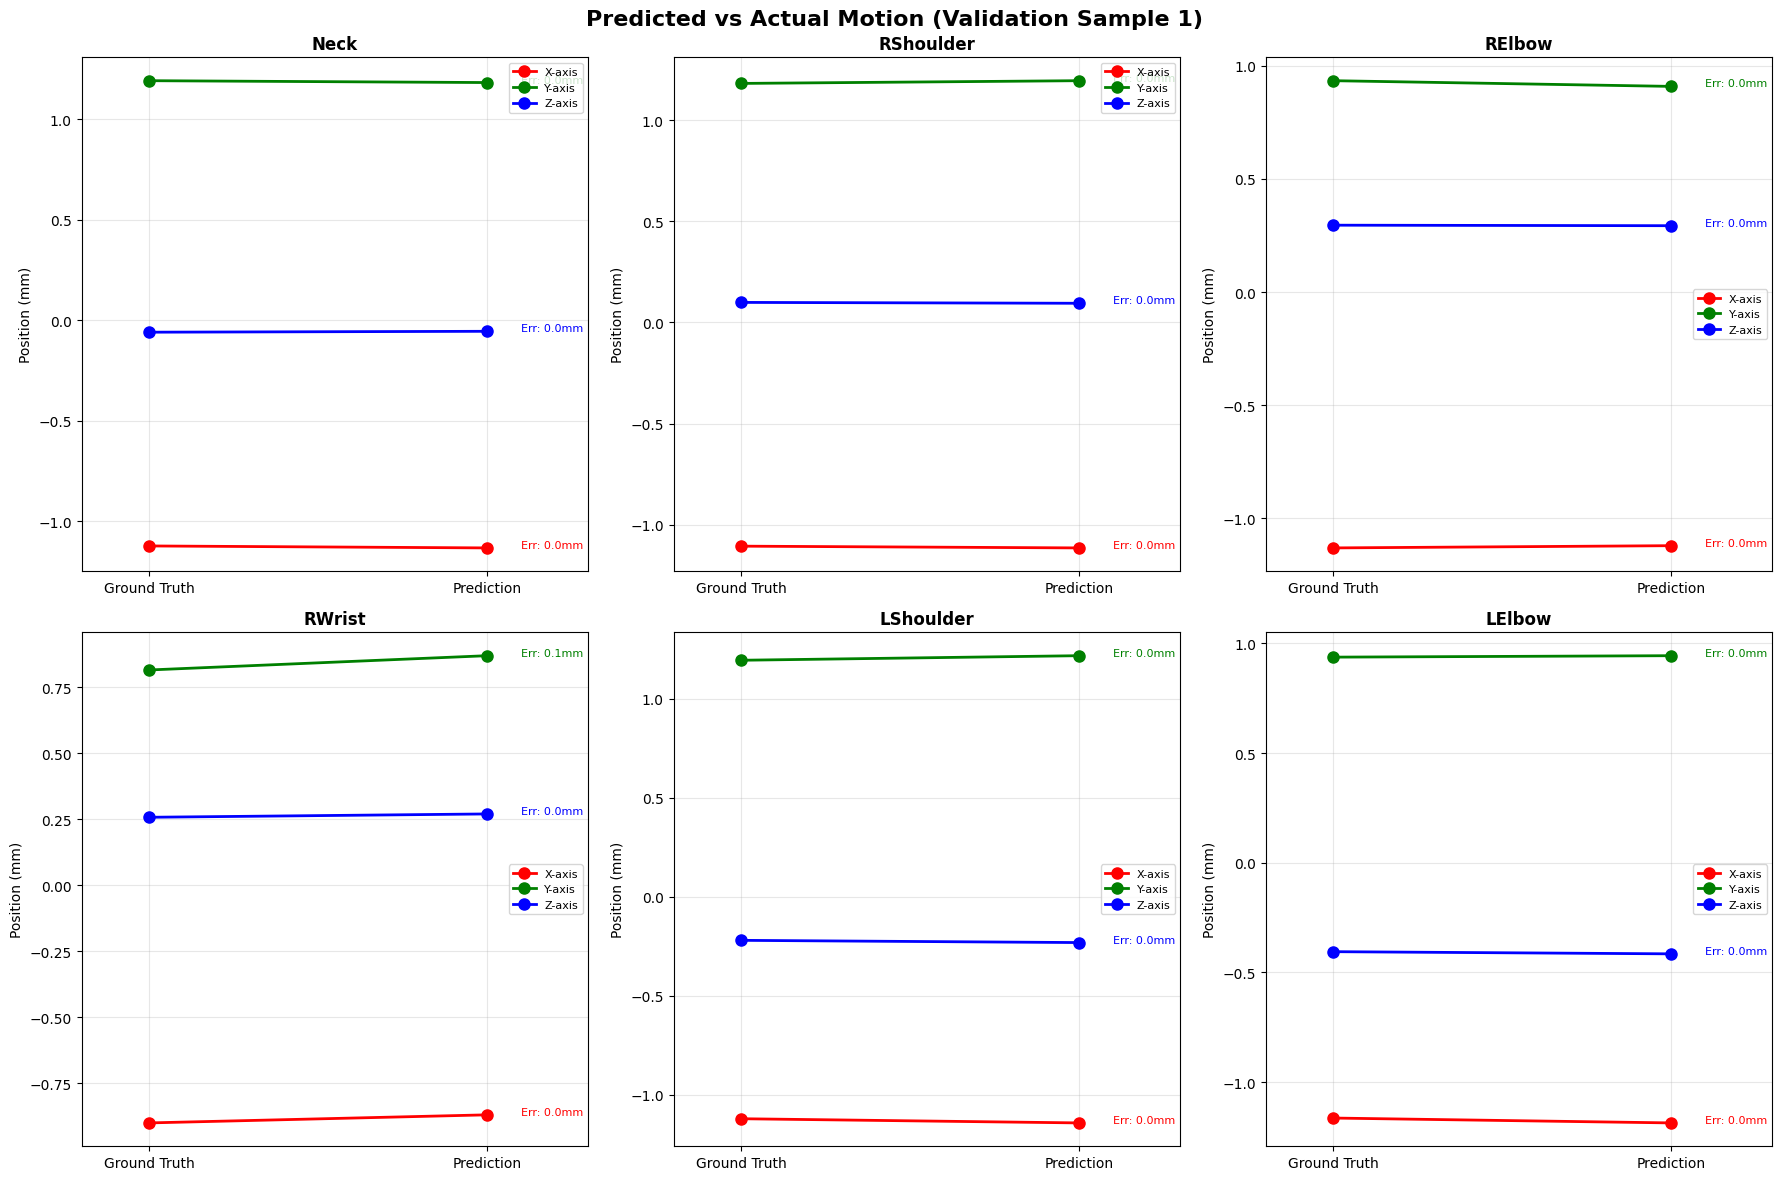

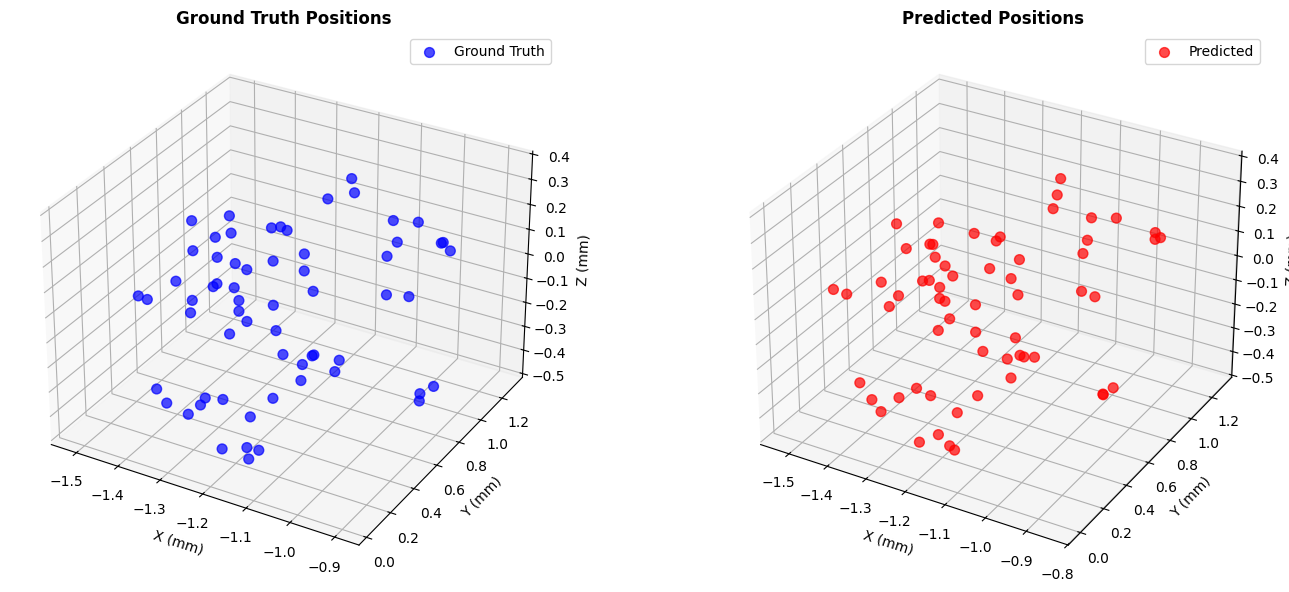

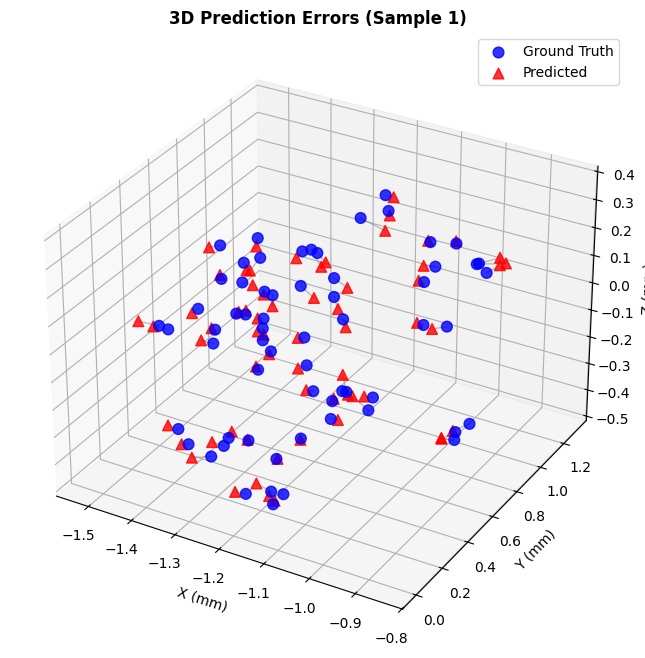

In [18]:
# Visualize predicted vs actual motion for selected markers
if len(predictions_denorm) > 0:
    sample_idx = 0
    markers_to_show = marker_names[:6] if len(marker_names) >= 6 else marker_names
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'Predicted vs Actual Motion (Validation Sample {sample_idx+1})', fontsize=16, fontweight='bold')
    
    for i, marker in enumerate(markers_to_show):
        row, col = i // 3, i % 3
        ax = axes[row, col]
        
        marker_idx = marker_names.index(marker)
        
        # Get predicted and actual positions
        pred_pos = predictions_denorm[sample_idx, marker_idx, :]
        true_pos = ground_truths_denorm[sample_idx, marker_idx, :]
        
        # Create x-axis (just showing single prediction point)
        x_pos = [0, 1]  # Two time points: actual and predicted
        
        # Plot each axis
        for axis_idx, (axis_name, color) in enumerate(zip(['X', 'Y', 'Z'], ['red', 'green', 'blue'])):
            ax.plot([0, 1], [true_pos[axis_idx], pred_pos[axis_idx]], 
                   color=color, marker='o', linewidth=2, markersize=8,
                   label=f'{axis_name}-axis')
            
            # Add error annotation
            error = abs(pred_pos[axis_idx] - true_pos[axis_idx])
            ax.annotate(f'Err: {error:.1f}mm', 
                       xy=(1, pred_pos[axis_idx]), 
                       xytext=(1.1, pred_pos[axis_idx]),
                       fontsize=8, color=color)
        
        ax.set_xlim(-0.2, 1.3)
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['Ground Truth', 'Prediction'])
        ax.set_ylabel('Position (mm)')
        ax.set_title(f'{marker}', fontweight='bold')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 3D visualization of predicted vs actual positions
    fig = plt.figure(figsize=(15, 6))
    
    # Ground truth 3D positions
    ax1 = fig.add_subplot(121, projection='3d')
    true_positions = ground_truths_denorm[sample_idx]
    ax1.scatter(true_positions[:, 0], true_positions[:, 1], true_positions[:, 2], 
               c='blue', s=50, alpha=0.7, label='Ground Truth')
    ax1.set_xlabel('X (mm)')
    ax1.set_ylabel('Y (mm)')
    ax1.set_zlabel('Z (mm)')
    ax1.set_title('Ground Truth Positions', fontweight='bold')
    ax1.legend()
    
    # Predicted 3D positions
    ax2 = fig.add_subplot(122, projection='3d')
    pred_positions = predictions_denorm[sample_idx]
    ax2.scatter(pred_positions[:, 0], pred_positions[:, 1], pred_positions[:, 2],
               c='red', s=50, alpha=0.7, label='Predicted')
    ax2.set_xlabel('X (mm)')
    ax2.set_ylabel('Y (mm)')
    ax2.set_zlabel('Z (mm)')
    ax2.set_title('Predicted Positions', fontweight='bold')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Error visualization in 3D
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot ground truth and predictions
    ax.scatter(true_positions[:, 0], true_positions[:, 1], true_positions[:, 2],
              c='blue', s=60, alpha=0.8, label='Ground Truth', marker='o')
    ax.scatter(pred_positions[:, 0], pred_positions[:, 1], pred_positions[:, 2],
              c='red', s=60, alpha=0.8, label='Predicted', marker='^')
    
    # Draw lines showing errors
    for i in range(len(marker_names)):
        ax.plot([true_positions[i, 0], pred_positions[i, 0]],
               [true_positions[i, 1], pred_positions[i, 1]],
               [true_positions[i, 2], pred_positions[i, 2]],
               'gray', alpha=0.5, linewidth=1)
    
    ax.set_xlabel('X (mm)')
    ax.set_ylabel('Y (mm)')
    ax.set_zlabel('Z (mm)')
    ax.set_title(f'3D Prediction Errors (Sample {sample_idx+1})', fontweight='bold')
    ax.legend()
    
    plt.show()

else:
    print("No predictions available for visualization.")

## Summary and Next Steps

This notebook demonstrated the implementation and testing of an autoregressive graph transformer for motion prediction. Here's what we accomplished:

### ✅ **Key Achievements:**

1. **Data Preparation**: Loaded motion capture data and computed kinematic features (position, velocity, acceleration)
2. **Graph Construction**: Created anatomically-informed graph representations using OpenSim conventions
3. **Model Architecture**: Implemented an autoregressive graph transformer (or LSTM fallback)
4. **Training**: Trained the model on motion sequences
5. **Evaluation**: Assessed prediction accuracy with multiple metrics
6. **Visualization**: Created comprehensive visualizations of results

### 📊 **Model Performance:**
- The model learned to predict future joint coordinates based on past motion
- Evaluation metrics include MAE, RMSE, and per-marker error analysis
- 3D visualizations show the spatial accuracy of predictions

### 🚀 **Future Improvements:**

1. **Enhanced Architecture**:
   - Implement attention mechanisms for better temporal modeling
   - Add graph attention for adaptive edge weighting
   - Include physics-based constraints

2. **Advanced Training**:
   - Use teacher forcing during training
   - Implement curriculum learning
   - Add adversarial training for realistic motion

3. **Data Augmentation**:
   - Temporal warping
   - Noise injection
   - Multi-scale training

4. **Applications**:
   - Real-time motion prediction
   - Gait analysis and pathology detection
   - Sports performance analysis
   - Virtual reality and animation

The autoregressive graph transformer provides a powerful framework for modeling human motion that respects anatomical constraints while learning complex temporal dependencies!